In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain_huggingface import HuggingFaceEmbeddings  # HuggingFace嵌入

load_dotenv("../.env")

model = ChatOpenAI(
                    temperature=0,
                    max_tokens=4096,
                    presence_penalty=1.2,
                    # model='deepseek-chat',
                    # openai_api_key=os.getenv('DEEPSEEK_API_KEY'),
                    # openai_api_base="https://api.deepseek.com/v1",
                    model='gpt-4o-mini',
                    openai_api_key=os.getenv('CLOSEAI_API_KEY'),
                    openai_api_base="https://api.openai-proxy.org/v1",
                )

# model = ChatOllama(
#                     temperature=0,
#                     num_predict=4096,
#                     repeat_penalty=1.2,
#                     model="llama3.2:3b"
#                 )

embedding = HuggingFaceEmbeddings(
            model_name="../../../../Embedding/maidalun/bce-embedding-base_v1",
            model_kwargs={"device": "cuda",
                          "trust_remote_code": True},
            encode_kwargs={"normalize_embeddings": True},
        )

c:\Users\farben\anaconda3\envs\lclg\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Define the tools

In [2]:
import re
import uuid

from langchain_core.tools import StructuredTool


def create_tool(company: str) -> dict:
    """Create schema for a placeholder tool."""
    # Remove non-alphanumeric characters and replace spaces with underscores for the tool name
    formatted_company = re.sub(r"[^\w\s]", "", company).replace(" ", "_")

    def company_tool(year: int) -> str:
        # Placeholder function returning static revenue information for the company and year
        return f"{company} had revenues of $100 in {year}."

    return StructuredTool.from_function(
        company_tool,
        name=formatted_company,
        description=f"Information about {company}",
    )


# Abbreviated list of S&P 500 companies for demonstration
s_and_p_500_companies = [
    "3M",
    "A.O. Smith",
    "Abbott",
    "Accenture",
    "Advanced Micro Devices",
    "Yum! Brands",
    "Zebra Technologies",
    "Zimmer Biomet",
    "Zoetis",
]

# Create a tool for each company and store it in a registry with a unique UUID as the key
tool_registry = {
    str(uuid.uuid4()): create_tool(company) for company in s_and_p_500_companies
}

# Define the graph

# Tool selection

In [3]:
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore

tool_documents = [
    Document(
        page_content=tool.description,
        id=id,
        metadata={"tool_name": tool.name},
    )
    for id, tool in tool_registry.items()
]

vector_store = InMemoryVectorStore(embedding=embedding)
document_ids = vector_store.add_documents(tool_documents)

c:\Users\farben\anaconda3\envs\lclg\Lib\site-packages\transformers\models\xlm_roberta\modeling_xlm_roberta.py:371: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


## Incorporating with an agent

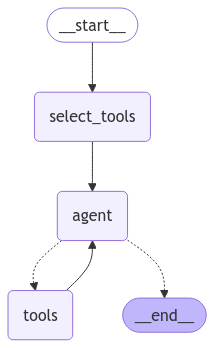

In [4]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


# Define the state structure using TypedDict.
# It includes a list of messages (processed by add_messages)
# and a list of selected tool IDs.
class State(TypedDict):
    messages: Annotated[list, add_messages]
    selected_tools: list[str]


builder = StateGraph(State)

# Retrieve all available tools from the tool registry.
tools = list(tool_registry.values())


# The agent function processes the current state
# by binding selected tools to the LLM.
def agent(state: State):
    # Map tool IDs to actual tools
    # based on the state's selected_tools list.
    selected_tools = [tool_registry[id] for id in state["selected_tools"]]
    # Bind the selected tools to the LLM for the current interaction.
    llm_with_tools = model.bind_tools(selected_tools)
    # Invoke the LLM with the current messages and return the updated message list.
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# The select_tools function selects tools based on the user's last message content.
def select_tools(state: State):
    last_user_message = state["messages"][-1]
    query = last_user_message.content
    tool_documents = vector_store.similarity_search(query)
    return {"selected_tools": [document.id for document in tool_documents]}


builder.add_node("agent", agent)
builder.add_node("select_tools", select_tools)

tool_node = ToolNode(tools=tools)
builder.add_node("tools", tool_node)

builder.add_conditional_edges("agent", tools_condition, path_map=["tools", "__end__"])
builder.add_edge("tools", "agent")
builder.add_edge("select_tools", "agent")
builder.add_edge(START, "select_tools")
graph = builder.compile()

graph

In [5]:
user_input = "Can you give me some information about AMD in 2022?"

result = graph.invoke({"messages": [("user", user_input)]})

In [6]:
print(result["selected_tools"])

['a2f074c2-1920-4d51-9393-33d857e4b0d7', '3fd30683-1b7e-44b8-b2ef-75aed615aad1', '44ceb002-243b-4e87-9121-de38448887ce', '352b5dab-6842-42ff-a582-1be988210e81']


In [7]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Can you give me some information about AMD in 2022?
================================== Ai Message ==================================
Tool Calls:
  Advanced_Micro_Devices (call_nP7DtkO290EokXIxLdhjgLXl)
 Call ID: call_nP7DtkO290EokXIxLdhjgLXl
  Args:
    year: 2022
================================= Tool Message =================================
Name: Advanced_Micro_Devices

Advanced Micro Devices had revenues of $100 in 2022.
================================== Ai Message ==================================

In 2022, Advanced Micro Devices (AMD) reported revenues of $100 million.


# Repeating tool selection

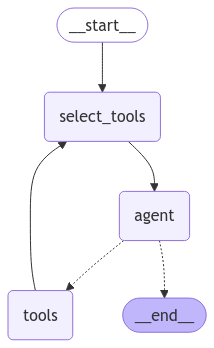

In [8]:
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langgraph.pregel.retry import RetryPolicy

from pydantic import BaseModel, Field


class QueryForTools(BaseModel):
    """Generate a query for additional tools."""

    query: str = Field(..., description="Query for additional tools.")


def select_tools(state: State):
    """Selects tools based on the last message in the conversation state.

    If the last message is from a human, directly uses the content of the message
    as the query. Otherwise, constructs a query using a system message and invokes
    the LLM to generate tool suggestions.
    """
    last_message = state["messages"][-1]
    hack_remove_tool_condition = False  # Simulate an error in the first tool selection

    if isinstance(last_message, HumanMessage):
        query = last_message.content
        hack_remove_tool_condition = True  # Simulate wrong tool selection
    else:
        assert isinstance(last_message, ToolMessage)
        system = SystemMessage(
            "Given this conversation, generate a query for additional tools. "
            "The query should be a short string containing what type of information "
            "is needed. If no further information is needed, "
            "set more_information_needed False and populate a blank string for the query."
        )
        input_messages = [system] + state["messages"]
        response = model.bind_tools([QueryForTools], tool_choice=True).invoke(
            input_messages
        )
        query = response.tool_calls[0]["args"]["query"]

    # Search the tool vector store using the generated query
    tool_documents = vector_store.similarity_search(query)
    if hack_remove_tool_condition:
        # Simulate error by removing the correct tool from the selection
        selected_tools = [
            document.id
            for document in tool_documents
            if document.metadata["tool_name"] != "Advanced_Micro_Devices"
        ]
    else:
        selected_tools = [document.id for document in tool_documents]
    return {"selected_tools": selected_tools}


graph_builder = StateGraph(State)
graph_builder.add_node("agent", agent)
graph_builder.add_node("select_tools", select_tools, retry=RetryPolicy(max_attempts=3))

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "agent",
    tools_condition,
)
graph_builder.add_edge("tools", "select_tools")
graph_builder.add_edge("select_tools", "agent")
graph_builder.add_edge(START, "select_tools")
graph = graph_builder.compile()

graph

In [9]:
user_input = "Can you give me some information about AMD in 2022?"

result = graph.invoke({"messages": [("user", user_input)]})

In [10]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Can you give me some information about AMD in 2022?
================================== Ai Message ==================================

I currently don't have access to specific information about AMD. However, I can provide information on companies like Accenture, 3M, and Abbott if you're interested. Let me know how you'd like to proceed!
